In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import joblib

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer 
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

shap.initjs()

---
## `PKDKodWoEEncoder` (Weight of Evidence Encoder)

Klasa transformująca zmienną kategoryczną 'pkdKod' na miarę Weight of Evidence (WoE). Służy do przygotowania zmiennych kategorycznych o dużej liczbie unikalnych wartości dla modeli scoringowych.

---

### **Działanie Kluczowe**
* Grupowanie Rzadkich Kategorii: Identyfikuje top_n najczęściej występujących kategorii. Wszystkie pozostałe kategorie (rzadkie) są grupowane w jedną kategorię oznaczoną jako '0'.

* Obliczanie WoE: Dla każdej z topowych kategorii i kategorii '0' oblicza WoE. WoE jest logarytmem naturalnym z ilorazu szans (Good/Bad) w danej grupie, podzielonego przez iloraz szans w całej próbie (Good_Total/Bad_Total).

$$WoE = \ln \left( \frac{P(\text{Good} | \text{Grupa})}{P(\text{Bad} | \text{Grupa})} / \frac{P(\text{Good Total})}{P(\text{Bad Total})} \right)$$

* Wygładzanie (Smoothing): Dodaje wartość smoothing (np. 0.5) do liczebności zdarzeń "Good" i "Bad" (dobrych i złych), aby uniknąć dzielenia przez zero i zmniejszyć wpływ małych prób.

* Transformacja: Zastępuje wartość pkdKod obliczoną wartością WoE. Oryginalna kolumna pkdKod jest usuwana.

In [29]:
class PKDKodWoEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=10, smoothing=0.5):
        self.top_n = top_n
        self.smoothing = smoothing
    
    def fit(self, X, y):
        X = X.copy()
        y = y.copy()
        
        self.top_values_ = X['pkdKod'].value_counts().nlargest(self.top_n).index
        
        grouped = X['pkdKod'].where(X['pkdKod'].isin(self.top_values_), other='0')
        
        df = pd.DataFrame({'group': grouped, 'target': y})
        agg = df.groupby('group')['target'].agg(['sum', 'count'])
        agg = agg.rename(columns={'sum':'bad', 'count':'total'})
        agg['good'] = agg['total'] - agg['bad']

        agg['bad_s'] = agg['bad'] + self.smoothing
        agg['good_s'] = agg['good'] + self.smoothing

        total_bad = agg['bad_s'].sum()
        total_good = agg['good_s'].sum()

        agg['woe'] = np.log((agg['good_s'] / total_good) / (agg['bad_s'] / total_bad))

        self.woe_map_ = agg['woe'].to_dict()
        self.fallback_ = agg.loc['0', 'woe'] if '0' in agg.index else np.mean(list(self.woe_map_.values()))
        
        return self
    
    def transform(self, X):
        X = X.copy()
        grouped = X['pkdKod'].where(X['pkdKod'].isin(self.top_values_), other='0')
        X['WoE_pkdKod_grouped'] = grouped.map(self.woe_map_).fillna(self.fallback_)
        return X.drop(columns=['pkdKod'])


---
## `DropConstantColumns` (Usuwanie stałych kolumn)

Prosty transformator, którego zadaniem jest identyfikacja i usunięcie z ramki danych kolumn, które mają **jedną lub zero unikalnych wartości** (są stałe).

---

### **Działanie Kluczowe**

* Fit: W fazie treningu (fit) identyfikuje kolumny, w których liczba unikalnych wartości (nunique()) jest mniejsza lub równa 1. Nazwy tych kolumn są przechowywane w self.cols_to_drop_.
* Transform: W fazie transformacji (transform) usuwa te zidentyfikowane kolumny z ramki danych.

In [30]:
class DropConstantColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.cols_to_drop_ = [col for col in X.columns if X[col].nunique() <= 1]
        return self

    def transform(self, X):
        return X.drop(columns=self.cols_to_drop_, errors='ignore')
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
             raise ValueError("input_features nie może być None dla DropConstantColumns")
        return [col for col in input_features if col not in self.cols_to_drop_]


---
## `MissingValueIndicatorAndImputer`

Ta klasa jest transformatorem scikit-learn, który realizuje dwie operacje jednocześnie na kolumnach numerycznych: imputację brakujących wartości oraz tworzenie kolumn-wskaźników braków danych.

---

### **Działanie Kluczowe**

* Obsługa Nieskończoności: Zamienia wartości nieskończone (np.inf, -np.inf) na braki danych (np.nan).
* Imputacja: Wykorzystuje SimpleImputer (strategia domyślna to mediana, ale można zmienić np. na mean lub most_frequent) do zastąpienia brakujących wartości. W fazie fit uczy się wartości imputacji, a w transform je stosuje.

* Wskaźnik Braków Danych: Tworzy nową kolumnę dla każdej oryginalnej kolumny, której nazwa kończy się na _mial_braki_danych. Wartość w tej kolumnie wynosi 1, jeśli oryginalna kolumna miała brak danych, i 0 w przeciwnym razie.

* Łączenie: Zwraca ramkę danych zawierającą zaimputowane oryginalne kolumny oraz nowo utworzone kolumny-wskaźniki.

In [31]:
class MissingValueIndicatorAndImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy="median"):
        self.strategy = strategy

    def fit(self, X, y=None):
        X = X.replace([np.inf, -np.inf], np.nan).copy()
        self.base_cols_ = list(X.columns)

        self.imputer_ = SimpleImputer(strategy=self.strategy)
        self.imputer_.fit(X[self.base_cols_])

        self.indicator_cols_ = [f"{c}_mial_braki_danych" for c in self.base_cols_]

        return self

    def transform(self, X):
        X = X.replace([np.inf, -np.inf], np.nan).copy()

        X_imputed = pd.DataFrame(
            self.imputer_.transform(X[self.base_cols_]),
            columns=self.base_cols_,
            index=X.index
        )

        indicator_df = X[self.base_cols_].isna().astype(int)
        indicator_df.columns = self.indicator_cols_
        indicator_df.index = X.index

        X_out = pd.concat([X_imputed, indicator_df], axis=1)

        return X_out
    
    def get_feature_names_out(self, input_features=None):
            base_cols = self.base_cols_
            indicator_cols = self.indicator_cols_
            return base_cols + indicator_cols

---
## `Podział Danych na Zbiory` Treningowy, Walidacyjny, Testowy

---

Treningowy (Train): Używany do uczenia modelu.

Walidacyjny (Validation/Val): Używany do strojenia hiperparametrów i wczesnego zatrzymywania treningu (early stopping).

Testowy (Test): Używany do ostatecznej, niezależnej oceny wydajności gotowego modelu.

Użyto dwóch kroków podziału, aby uzyskać proporcje około 70% / 15% / 15% (Train / Val / Test).

In [32]:
# Wczytanie danych
data = pd.read_csv("zbiór_10.csv")

# Definicja cech X i y
X = data.drop(columns=["default"])
y = data["default"]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.18, random_state=42)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 2091, Val: 459, Test: 450


---
## `Kodowanie WoE dla Kolumny pkdKod`

---

Ten proces demonstruje kluczową technikę w pre-processingu danych, jaką jest kodowanie Weight of Evidence (WoE), stosowaną na zmiennej kategorycznej pkdKod. Najważniejszą zasadą jest dopasowanie (fit) transformatora wyłącznie do danych treningowych, aby zapewnić, że wiedza o rozkładzie targetu (y) w kategoriach nie wycieknie do zbiorów walidacyjnych i testowych.

In [33]:
print("Fitting WoE Encoder...")
woe_encoder = PKDKodWoEEncoder(top_n=10, smoothing=0.5)

woe_encoder.fit(X_train, y_train)

X_train_woe = woe_encoder.transform(X_train)
X_val_woe = woe_encoder.transform(X_val)
X_test_woe = woe_encoder.transform(X_test)

print("WoE encoding complete.")

Fitting WoE Encoder...
WoE encoding complete.


---
## `Budowa Pipeline'u Preprocessingowego`

---

Poniższy opis definiuje kompleksowy potok (Pipeline) do automatycznego przetwarzania różnych typów cech w zbiorze danych. Użycie ColumnTransformer pozwala na jednoczesne stosowanie różnych transformatorów do cech numerycznych i kategorycznych.

---
### **Definicja Cech**

Po wstępnym kodowaniu WoE kolumny pkdKod, pozostałe kolumny są dzielone na numeryczne i kategoryczne (te, które będą kodowane One-Hot Encodingiem - OHE).

* Cechy Kategoryczne (do OHE): formaWlasnosci_Symbol, schemat_wsk_bilans, schemat_wsk_rzis.

* Cechy Numeryczne: Wszystkie pozostałe kolumny (włączając już przetworzoną cechę WoE).

### **Potok Cech Numerycznych**

Potok dla cech numerycznych jest sekwencją trzech kroków transformacji:

* Imputacja i Wskaźnik Braków (MissingValueIndicatorAndImputer): Wypełnienie brakujących wartości (mediana) oraz utworzenie pomocniczych kolumn binarnych sygnalizujących, gdzie pierwotnie wystąpił brak danych.

* Usunięcie Stałych Kolumn (DropConstantColumns): Identyfikacja i usunięcie cech, które po imputacji (lub z natury) mają jedną lub zero unikalnych wartości.

* Skalowanie (StandardScaler): Standaryzacja pozostałych cech numerycznych (przesunięcie do średniej 0 i skalowanie do odchylenia standardowego 1).

### **Potok Cech Kategorycznych**

Potok ten stosuje One-Hot Encoding (OneHotEncoder) do wcześniej zdefiniowanych cech kategorycznych. Opcja ignorowania nieznanych kategorii (handle_unknown='ignore') jest kluczowa, aby uniknąć błędów, jeśli w zbiorze walidacyjnym lub testowym pojawi się kategoria nieobecna w danych treningowych.

### **ColumnTransformer**

ColumnTransformer łączy oba potoki, stosując je do odpowiednich list cech. Cechy numeryczne trafiają do numeric_transformer, a kategoryczne do categorical_transformer. Opcja remainder='passthrough' jest ustawiona, by zapewnić, że wszystkie kolumny, które nie zostały objęte żadnym z potoków, zostaną włączone do wyjściowego zbioru danych bez zmian.


In [34]:
categorical_features = [
    'formaWlasnosci_Symbol', 
    'schemat_wsk_bilans', 
    'schemat_wsk_rzis'
]

numerical_features = [
    col for col in X_train_woe.columns if col not in categorical_features
]


numeric_transformer = Pipeline(steps=[
    ('missing', MissingValueIndicatorAndImputer(strategy="median")),
    ('drop_constant', DropConstantColumns()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

---
## `Finalny Potok Modelowania z XGBoost`

---

Ten kod definiuje kompletny potok modelowania (Pipeline), który integruje wszystkie wcześniej zdefiniowane kroki przetwarzania danych (preprocessor) z modelem XGBoost Classifier. Jest to standardowa i zalecana praktyka w uczeniu maszynowym, która zapewnia, że procesy pre-processingu są stosowane konsekwentnie podczas treningu, walidacji i testowania.

Obiekt pipeline jest teraz gotowy do dopasowania do danych treningowych (pipeline.fit(X_train, y_train)). Używając tego potoku, zapewniamy, że podczas treningu i predykcji wszystkie dane przechodzą przez identyczną sekwencję transformacji, co jest niezbędne dla rzetelności modelu.

In [35]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=1000,
    learning_rate=0.05,
    eval_metric='auc',
    early_stopping_rounds=50,
    random_state=42,
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() 
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

---
## `Eksport Wytrenowanego Pipeline'u do Pliku PKL`

---

Po wytrenowaniu modelu, konieczne jest zapisanie całego obiektu pipeline (zawierającego zarówno transformacje, jak i model XGBoost) do pliku. Używamy do tego biblioteki joblib, która jest wydajna przy dużych obiektach, takich jak modele scikit-learn i pipeline'y.

In [36]:
X_val_processed = pipeline['preprocessor'].fit(X_train_woe).transform(X_val_woe)

fit_params = {
    'model__eval_set': [(X_val_processed, y_val)],
    'model__verbose' : 100
}

pipeline.fit(X_train_woe, y_train, **fit_params)

joblib.dump(pipeline, 'XGBoost_model_pipeline.pkl')

print("Pipeline training complete.")
print("Model was successfully exported to file 'XGBoost_model_pipeline.pkl'.")

[0]	validation_0-auc:0.69071
[94]	validation_0-auc:0.77072
Pipeline training complete.
Model was successfully exported to file 'XGBoost_model_pipeline.pkl'.


---
## `Eksport Wytrenowanego Pipeline'u do Pliku PKL`

---

Po wytrenowaniu modelu, konieczne jest zapisanie całego obiektu pipeline (zawierającego zarówno transformacje, jak i model XGBoost) do pliku. Używamy do tego biblioteki joblib, która jest wydajna przy dużych obiektach, takich jak modele scikit-learn i pipeline'y.

In [37]:
preprocessor = pipeline.named_steps['preprocessor']
model = pipeline.named_steps['model']

try:
    final_feature_names = preprocessor.get_feature_names_out()
    print(f"Pobrano {len(final_feature_names)} finalnych nazw cech.")
except Exception as e:
    print(f"Błąd przy get_feature_names_out: {e}")

X_test_transformed_np = preprocessor.transform(X_test_woe)

X_test_transformed_df = pd.DataFrame(
    X_test_transformed_np, 
    columns=final_feature_names, 
    index=X_test_woe.index
)

print("Dane dla SHAP przygotowane.")

Pobrano 248 finalnych nazw cech.
Dane dla SHAP przygotowane.


In [38]:
explainer = shap.TreeExplainer(model)

print("Obliczanie wartości SHAP...")
shap_values_all_classes = explainer(X_test_transformed_df)
print("Wartości SHAP obliczone.")

if len(shap_values_all_classes.values.shape) == 3:
    print("Wykryto output dla 2 klas. Wybieram klasę 1 (Default).")
    # To tworzy nowy, "chudszy" obiekt Explanation tylko dla klasy 1
    shap_values = shap_values_all_classes[:, :, 1]
    
    # Pobieramy też wartość bazową dla klasy 1
    baseline = float(shap_values_all_classes.base_values[0, 1])
else:
    print("Wykryto output dla 1 klasy. Używam go bezpośrednio.")
    shap_values = shap_values_all_classes
    baseline = float(shap_values_all_classes.base_values[0])

print(f"Baseline (wartość bazowa log-odds): {baseline:.4f}")

Obliczanie wartości SHAP...
Wartości SHAP obliczone.
Wykryto output dla 1 klasy. Używam go bezpośrednio.
Baseline (wartość bazowa log-odds): 0.0029


In [39]:
# Wybierzmy pierwszą obserwację z danych testowych
idx = 0
obserwacja_idx = X_test_transformed_df.index[idx] # Prawdziwy indeks z danych
przetworzone_dane_obs = X_test_transformed_df.iloc[[idx]]

# Suma wkładów SHAP dla tej obserwacji
shap_sum = float(shap_values.values[idx].sum())

# Predykcja modelu (w skali log-odds, której używa SHAP)
# Używamy explainer.model.predict, aby dostać "surowy" output
raw_prediction = model.predict(przetworzone_dane_obs, output_margin=True)[0]

print("\n🔍 Weryfikacja dla pierwszej obserwacji testowej:")
print("=" * 60)
print(f"Baseline (wartość bazowa):         {baseline:.4f}")
print(f"Suma wartości SHAP:                {shap_sum:+.4f}")
print(f"Baseline + Suma SHAP:              {baseline + shap_sum:.4f}")
print(f"Surowa predykcja modelu (log-odds): {raw_prediction:.4f}")

if abs((baseline + shap_sum) - raw_prediction) < 1e-5:
    print("\nWeryfikacja PASSED! Wyjaśnienia są spójne z modelem.")
else:
    print("\nWeryfikacja FAILED! Coś poszło nie tak.")


🔍 Weryfikacja dla pierwszej obserwacji testowej:
Baseline (wartość bazowa):         0.0029
Suma wartości SHAP:                -1.4264
Baseline + Suma SHAP:              -1.4235
Surowa predykcja modelu (log-odds): -1.4235

Weryfikacja PASSED! Wyjaśnienia są spójne z modelem.


Globalna ważność cech (Beeswarm):


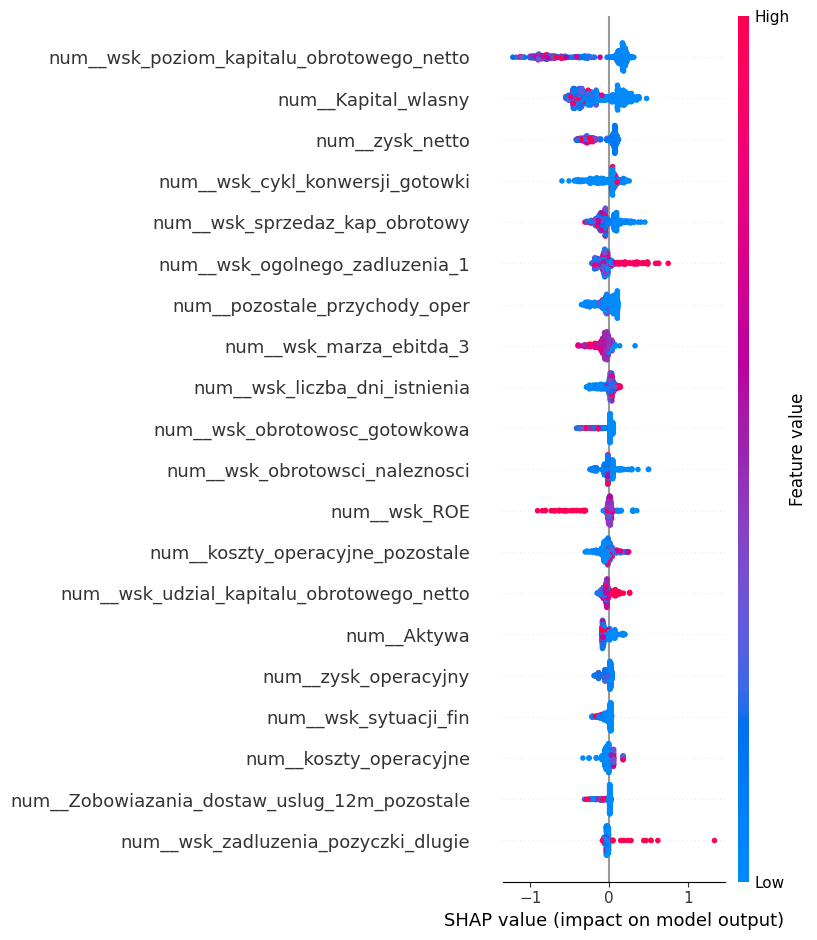

In [40]:
print("Globalna ważność cech (Beeswarm):")
# Używamy `shap_values` (dla klasy 1) i `X_test_transformed_df` (dla wartości cech)
shap.summary_plot(shap_values, X_test_transformed_df)

Wykres zależności dla: num__wsk_poziom_kapitalu_obrotowego_netto


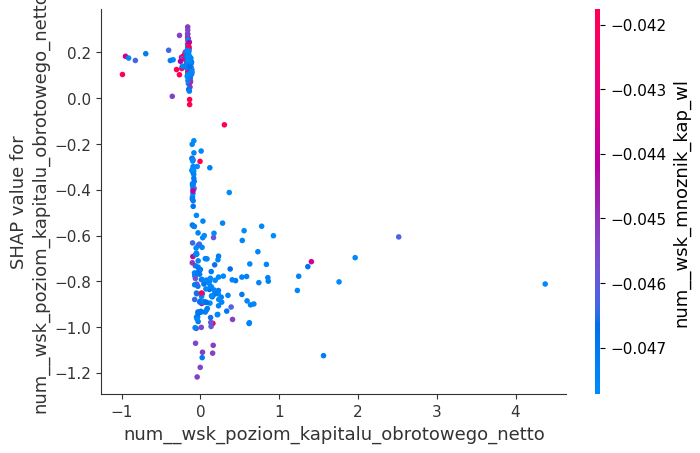

In [41]:
CECHA = 'num__wsk_poziom_kapitalu_obrotowego_netto'

print(f"Wykres zależności dla: {CECHA}")

shap.dependence_plot(
    CECHA,
    shap_values.values,     # Wartości SHAP (z obiektu)
    X_test_transformed_df,  # Przetworzone dane (z nazwami kolumn)
    interaction_index="auto" # Automatycznie znajdź interakcję
)

Wykres zależności dla: num__Kapital_wlasny


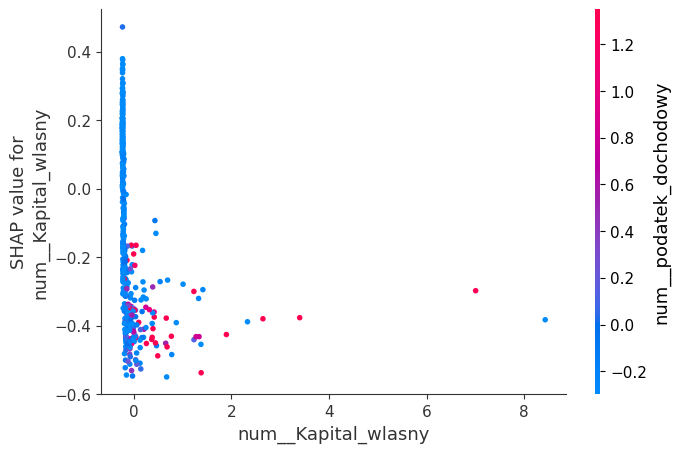

In [42]:
CECHA = 'num__Kapital_wlasny'

print(f"Wykres zależności dla: {CECHA}")

shap.dependence_plot(
    CECHA,
    shap_values.values,     # Wartości SHAP (z obiektu)
    X_test_transformed_df,  # Przetworzone dane (z nazwami kolumn)
    interaction_index="auto" # Automatycznie znajdź interakcję
)

Wykres zależności dla: num__zysk_netto


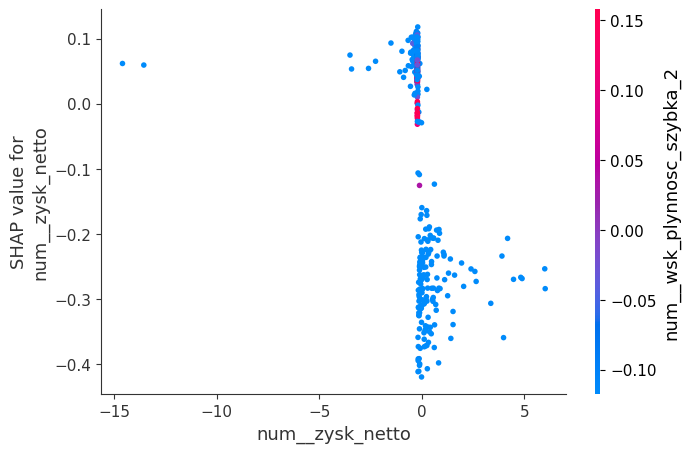

In [43]:
CECHA = 'num__zysk_netto'

print(f"Wykres zależności dla: {CECHA}")

shap.dependence_plot(
    CECHA,
    shap_values.values,     # Wartości SHAP (z obiektu)
    X_test_transformed_df,  # Przetworzone dane (z nazwami kolumn)
    interaction_index="auto" # Automatycznie znajdź interakcję
)

Wykres zależności dla: num__wsk_cykl_konwersji_gotowki


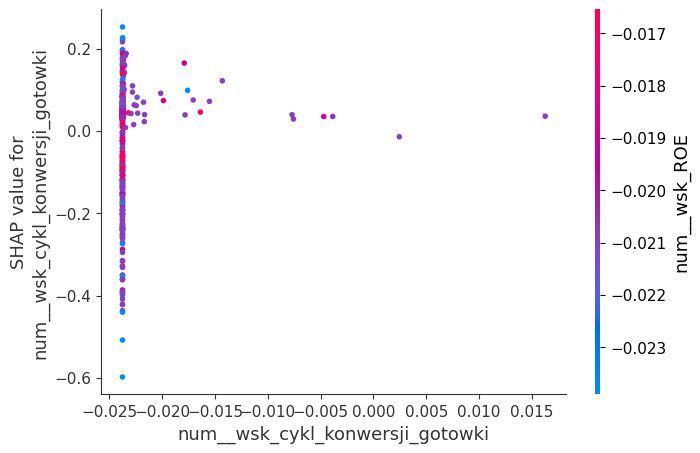

In [44]:
CECHA = 'num__wsk_cykl_konwersji_gotowki'

print(f"Wykres zależności dla: {CECHA}")

shap.dependence_plot(
    CECHA,
    shap_values.values,     # Wartości SHAP (z obiektu)
    X_test_transformed_df,  # Przetworzone dane (z nazwami kolumn)
    interaction_index="auto" # Automatycznie znajdź interakcję
)

Wykres zależności dla: num__wsk_sprzedaz_kap_obrotowy


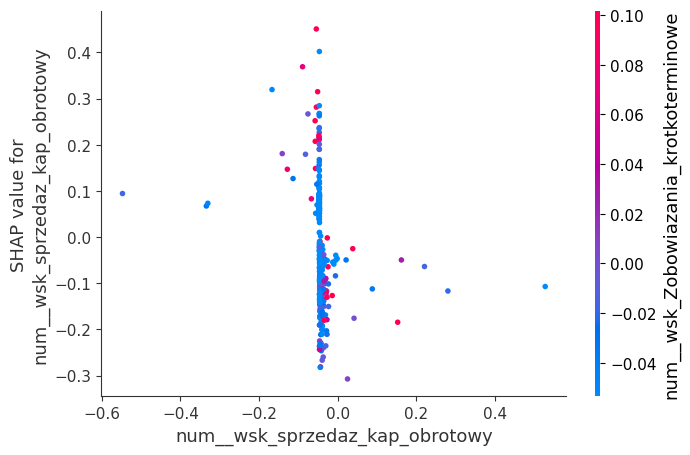

In [45]:
CECHA = 'num__wsk_sprzedaz_kap_obrotowy'

print(f"Wykres zależności dla: {CECHA}")

shap.dependence_plot(
    CECHA,
    shap_values.values,     # Wartości SHAP (z obiektu)
    X_test_transformed_df,  # Przetworzone dane (z nazwami kolumn)
    interaction_index="auto" # Automatycznie znajdź interakcję
)

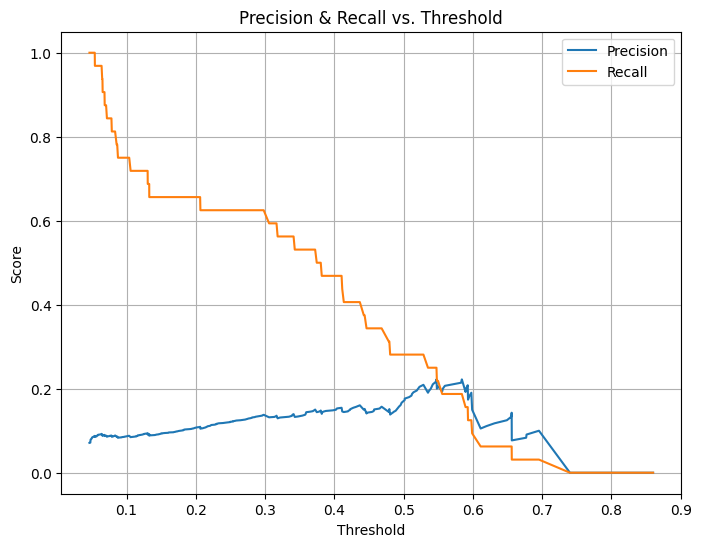


--- Optimal Threshold Finder ---
Best F1-Score: 0.2400
Found at Threshold: 0.5285

--- Model Evaluation ---
Test Accuracy: 0.8733
Best Iteration: 45
Best Score (Validation AUC): 0.7894

--- Classification Report (Threshold = 0.5285) ---
                precision    recall  f1-score   support

No Default (0)       0.94      0.92      0.93       418
   Default (1)       0.21      0.28      0.24        32

      accuracy                           0.87       450
     macro avg       0.58      0.60      0.59       450
  weighted avg       0.89      0.87      0.88       450

--- Confusion Matrix (Threshold = {best_threshold:.4f}) ---
[[384  34]
 [ 23   9]]


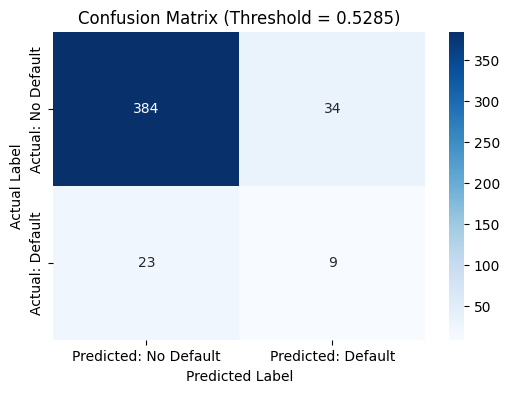

In [46]:
# Finding optimal threshold:
y_proba = pipeline.predict_proba(X_test_woe)[:, 1]


# plot
precision, recall, thresholds = precision_recall_curve(y_test, y_proba, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()


# best choice
f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)

best_f1_index = np.argmax(f1_scores)

best_threshold = thresholds[best_f1_index]
best_f1_score = f1_scores[best_f1_index]

print(f"\n--- Optimal Threshold Finder ---")
print(f"Best F1-Score: {best_f1_score:.4f}")
print(f"Found at Threshold: {best_threshold:.4f}")


# wyciąganie prawdopodobienstw wiekszych rownych naszemu threshold
y_pred_best = (y_proba >= best_threshold).astype(int)


# printing parameters
accuracy = accuracy_score(y_test, y_pred_best)
print(f"\n--- Model Evaluation ---")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Best Iteration: {pipeline.named_steps['model'].best_iteration}")
print(f"Best Score (Validation AUC): {pipeline.named_steps['model'].best_score:.4f}")


# classification report
print(f"\n--- Classification Report (Threshold = {best_threshold:.4f}) ---")
print(classification_report(y_test, y_pred_best, target_names=['No Default (0)', 'Default (1)']))


# confusion matrix
print("--- Confusion Matrix (Threshold = {best_threshold:.4f}) ---")
cm = confusion_matrix(y_test, y_pred_best)
print(cm)


# heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: No Default', 'Predicted: Default'], 
            yticklabels=['Actual: No Default', 'Actual: Default'])
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.4f})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
plt.show()


--- Wyjaśnienie dla obserwacji FALSE NEGATIVE (Indeks: 63) ---


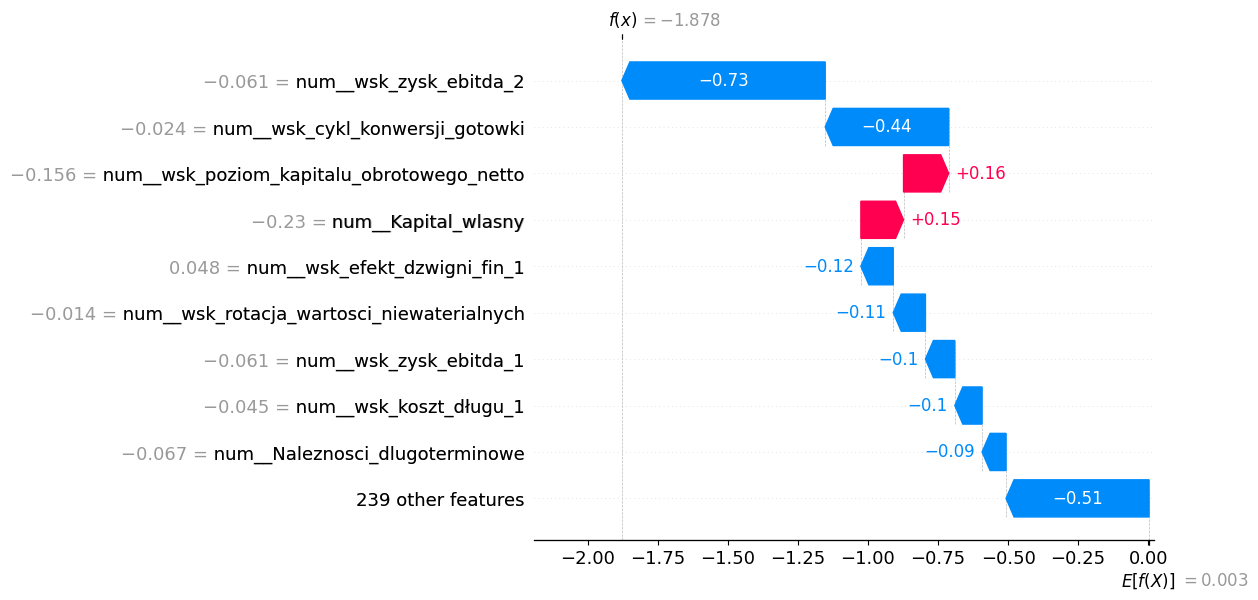

In [47]:
# Znajdźmy indeksy FN (False Negative) - NAJWAŻNIEJSZE POMYŁKI
fn_indices = X_test_woe[(y_pred_best == 0) & (y_test == 1)].index

if not fn_indices.empty:
    # Bierzemy pierwszego klienta, którego model BŁĘDNIE uznał za bezpiecznego
    idx_to_explain = fn_indices[1] 
    
    # Znajdujemy jego pozycję w naszych przetworzonych danych
    idx_position = X_test_transformed_df.index.get_loc(idx_to_explain)

    print(f"\n--- Wyjaśnienie dla obserwacji FALSE NEGATIVE (Indeks: {idx_to_explain}) ---")
    
    # Wykres Waterfall - idealny do analizy "co poszło nie tak"
    # Używamy obiektu `shap_values` z indeksem pozycyjnym
    shap.plots.waterfall(shap_values[idx_position])
    
else:
    print("Gratulacje, brak pomyłek False Negative do analizy.")

Analizuję 23 przypadków False Negative...
Generuję wykres 'summary_plot' tylko dla przypadków FN:


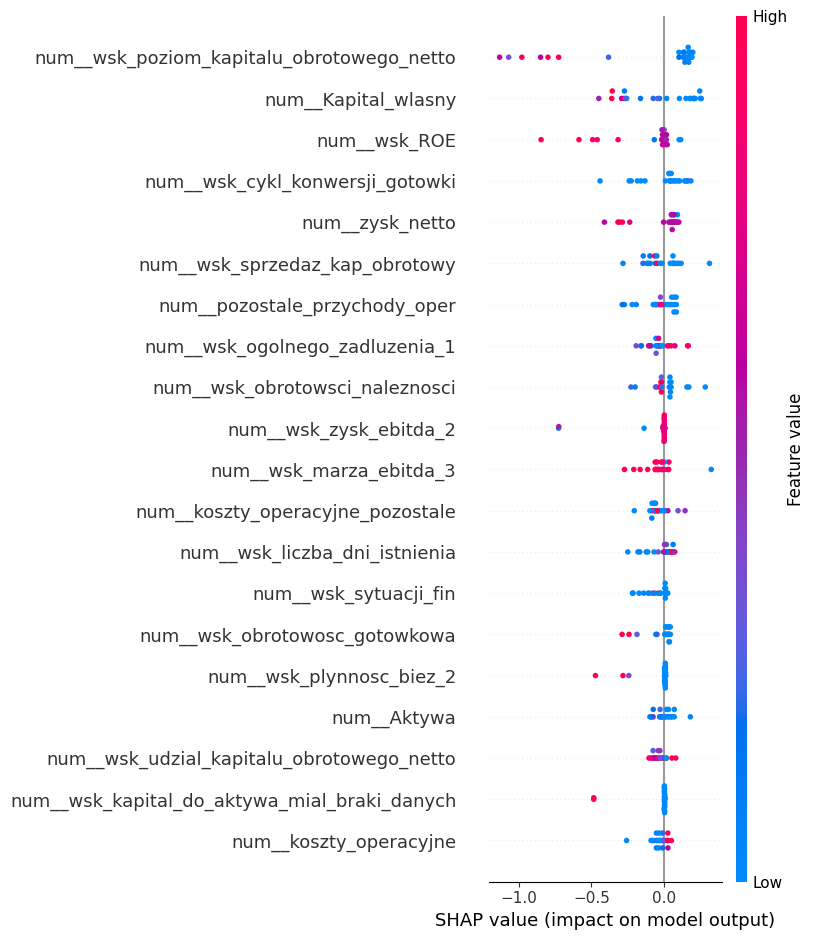

In [48]:
# 1. Znajdźmy indeksy FN (False Negative)
fn_indices = X_test_woe[(y_pred_best == 0) & (y_test == 1)].index

if not fn_indices.empty:
    print(f"Analizuję {len(fn_indices)} przypadków False Negative...")
    
    # 2. Znajdźmy ich POZYCJE w przetworzonych danych
    #    ↓↓↓ POPRAWIONA LINIA ↓↓↓
    # Używamy get_indexer, aby zamienić listę indeksów na listę pozycji
    fn_positions = X_test_transformed_df.index.get_indexer(fn_indices)
    
    # (Opcjonalnie) Usuńmy "-1", jeśli jakiś indeks się nie znalazł
    fn_positions = fn_positions[fn_positions != -1]

    # 3. Wygeneruj summary_plot TYLKO dla tych pozycji
    print("Generuję wykres 'summary_plot' tylko dla przypadków FN:")
    
    shap.summary_plot(
        shap_values[fn_positions], 
        X_test_transformed_df.iloc[fn_positions]
    )
    
else:
    print("Brak pomyłek False Negative do analizy.")

In [49]:
def expected_calibration_error(y_true, p, n_bins=10):
    """
    Oblicza Oczekiwany Błąd Kalibracji (ECE).
    """
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        mask = (p >= bins[i]) & (p < bins[i+1])
        if mask.any():
            # Średnia predykcja (pewność) w koszyku
            conf = p[mask].mean()
            # Rzeczywisty odsetek pozytywny (celność) w koszyku
            acc = y_true[mask].mean()
            ece += (mask.sum()/len(p)) * abs(acc - conf)
    return ece

def reliability_plot(y_true, p, title):
    """
    Rysuje krzywą reliability (wiarygodności).
    """
    # strategy='uniform' dzieli zakres 0-1 na równe koszyki
    frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=10, strategy='uniform')
    
    plt.figure(figsize=(7, 6))
    plt.plot([0,1],[0,1], '--', label='Perfekcyjna kalibracja') # Idealna linia
    plt.plot(mean_pred, frac_pos, marker='o', label='Model XGBoost')
    plt.title(title)
    plt.xlabel("Średnia prognozowana PD (Pewność)")
    plt.ylabel("Rzeczywista częstość zdarzeń (Celność)")
    plt.legend()
    plt.grid(True)
    plt.show()

def hist_predictions(p, title):
    """
    Rysuje histogram przewidywanych prawdopodobieństw.
    """
    plt.figure(figsize=(7, 5))
    plt.hist(p, bins=30, edgecolor='k', alpha=0.7)
    plt.title(title)
    plt.xlabel("Prognozowane Prawdopodobieństwo (PD)")
    plt.ylabel("Liczność obserwacji")
    plt.grid(axis='y')
    plt.show()

---  DIAGNOSTYKA MODELU (PRE-CALIBRATION) ---


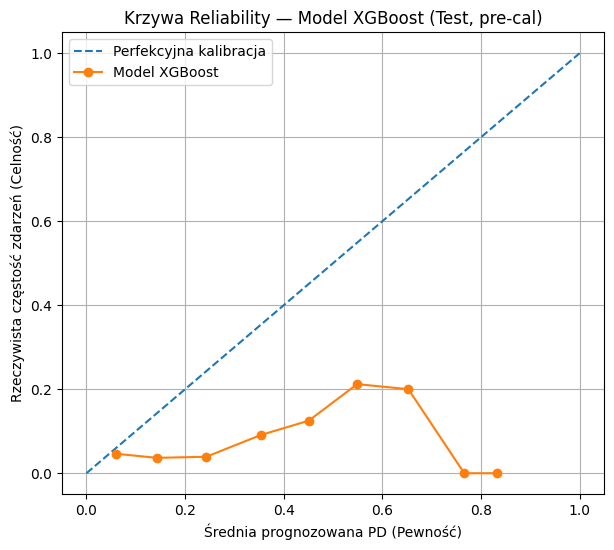

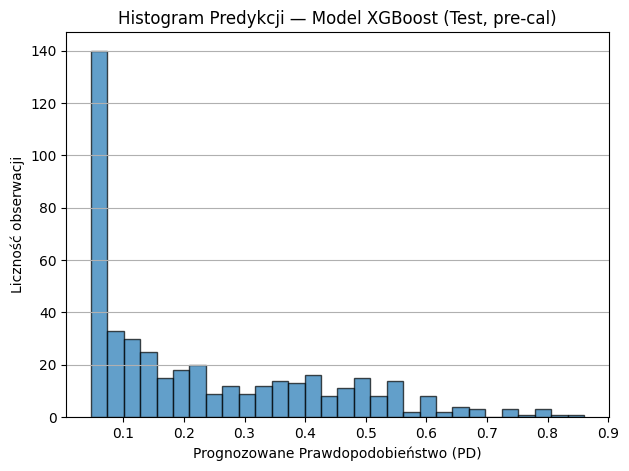


Wyniki (pre-cal):
  Oczekiwany Błąd Kalibracji (ECE): 0.1587
  Wynik Briera (Brier Score):       0.1130


In [50]:
if 'y_test' in locals() and 'y_proba' in locals():
    print("---  DIAGNOSTYKA MODELU (PRE-CALIBRATION) ---")
    
    # 1. Krzywa Reliability
    reliability_plot(y_test, y_proba, "Krzywa Reliability — Model XGBoost (Test, pre-cal)")
    
    # 2. Histogram Predykcji
    hist_predictions(y_proba, "Histogram Predykcji — Model XGBoost (Test, pre-cal)")
    
    # 3. Metryki ECE i Brier
    ece_pre = expected_calibration_error(y_test, y_proba, n_bins=10)
    brier_pre = brier_score_loss(y_test, y_proba)
    
    print(f"\nWyniki (pre-cal):")
    print(f"  Oczekiwany Błąd Kalibracji (ECE): {ece_pre:.4f}")
    print(f"  Wynik Briera (Brier Score):       {brier_pre:.4f}")

else:
    print("BŁĄD: Zmienne 'y_test' lub 'y_proba' nie zostały znalezione.")
    print("Upewnij się, że uruchomiłaś komórki obliczające te wartości.")

In [51]:
def fit_platt(y, p):
    # Sigmoida: lr na logitach
    eps = 1e-12
    # Przekształcamy prawdopodobieństwo (p) na log-odds (logity)
    logit = np.log(np.clip(p, eps, 1-eps) / np.clip(1-p, eps, 1-eps))
    lr = LogisticRegression(max_iter=500, C=1e6) # Używamy wysokiego C dla "czystego" Platta
    lr.fit(logit.reshape(-1,1), y)
    return lr

def apply_platt(lr, p):
    eps = 1e-12
    logit = np.log(np.clip(p, eps, 1-eps) / np.clip(1-p, eps, 1-eps))
    # Zwracamy prawdopodobieństwo z regresji logistycznej
    return lr.predict_proba(logit.reshape(-1,1))[:,1]

def fit_isotonic(y, p):
    ir = IsotonicRegression(out_of_bounds='clip')
    # Regresja izotoniczna uczy się bezpośrednio na prawdopodobieństwach
    ir.fit(p, y)
    return ir

def apply_isotonic(ir, p):
    return ir.transform(p)

Obliczanie prognoz dla zbioru walidacyjnego...
Dopasowywanie kalibratorów na zbiorze walidacyjnym...
Kalibratory wytrenowane.
Stosowanie kalibratorów na zbiorze testowym...

--- OCENA (POST-CALIBRATION) ---

--- Model: Platt (post-cal) ---


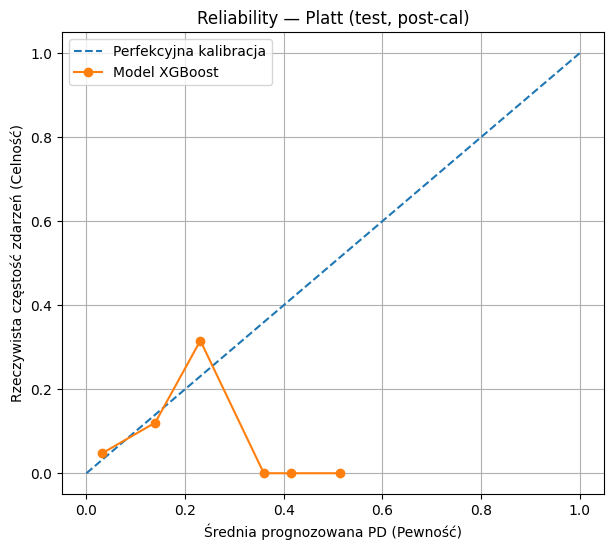

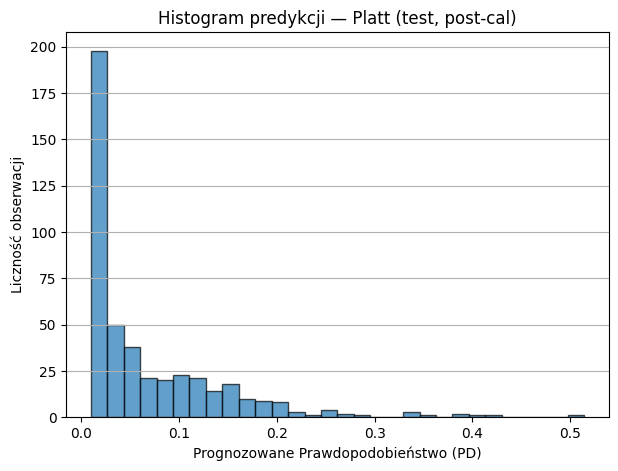

Wyniki dla Platt (post-cal):
  Oczekiwany Błąd Kalibracji (ECE): 0.0268
  Wynik Briera (Brier Score):       0.0665

--- Model: Isotonic (post-cal) ---


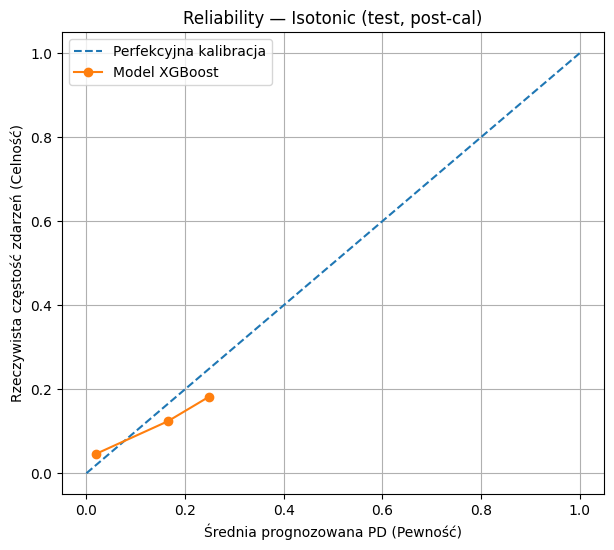

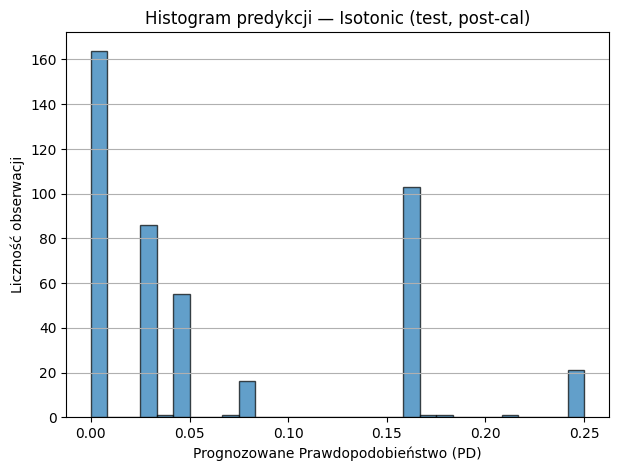

Wyniki dla Isotonic (post-cal):
  Oczekiwany Błąd Kalibracji (ECE): 0.0318
  Wynik Briera (Brier Score):       0.0656


In [52]:
# Sprawdzamy, czy wszystkie potrzebne zmienne istnieją
if 'pipeline' in locals() and 'y_val' in locals() and 'X_val_woe' in locals() and 'y_test' in locals() and 'y_proba' in locals():
    
    # KROK 1: Oblicz prognozy dla zbioru WALIDACYJNEGO
    print("Obliczanie prognoz dla zbioru walidacyjnego...")
    y_proba_val = pipeline.predict_proba(X_val_woe)[:, 1]
    
    # Zmieniamy nazwę starych prognoz testowych dla jasności
    y_proba_test_pre_cal = y_proba 

    # KROK 2: Dopasuj kalibratory na zbiorze WALIDACYJNYM
    print("Dopasowywanie kalibratorów na zbiorze walidacyjnym...")
    platt_model = fit_platt(y_val, y_proba_val)
    iso_model = fit_isotonic(y_val, y_proba_val)
    print("Kalibratory wytrenowane.")

    # KROK 3: Zastosuj kalibratory na zbiorze TESTOWYM
    print("Stosowanie kalibratorów na zbiorze testowym...")
    y_proba_test_platt = apply_platt(platt_model, y_proba_test_pre_cal)
    y_proba_test_iso   = apply_isotonic(iso_model, y_proba_test_pre_cal)

    # KROK 4: Ocena POST-CAL (kod od prowadzącego)
    print("\n--- OCENA (POST-CALIBRATION) ---")
    
    # Przechowujemy nowe prognozy do późniejszego użytku
    calibrated_probas = {
        'Platt': y_proba_test_platt,
        'Isotonic': y_proba_test_iso
    }
    
    for name, p in calibrated_probas.items():
        print(f"\n--- Model: {name} (post-cal) ---")
        
        # Prowadzący miał tu funkcję basic_metrics, ale nie jest ona kluczowa do oceny *kalibracji*
        # print(f"{name} (test):", basic_metrics(y_te, p)) 
        
        reliability_plot(y_test, p, f"Reliability — {name} (test, post-cal)")
        hist_predictions(p, f"Histogram predykcji — {name} (test, post-cal)")
        
        # Obliczamy nowe metryki kalibracji
        ece_post = expected_calibration_error(y_test, p, n_bins=10)
        brier_post = brier_score_loss(y_test, p)
        
        print(f"Wyniki dla {name} (post-cal):")
        print(f"  Oczekiwany Błąd Kalibracji (ECE): {ece_post:.4f}")
        print(f"  Wynik Briera (Brier Score):       {brier_post:.4f}")

else:
    print("BŁĄD: Brakuje kluczowych zmiennych (np. 'pipeline', 'y_val', 'X_val_woe', 'y_test', 'y_proba').")
    print("Upewnij się, że wszystkie poprzednie komórki zostały uruchomione.")

In [53]:
# wybieramy isotonic

In [54]:
def logit_fn(p, eps=1e-12):
    """Przekształca prawdopodobieństwo na log-odds (logity)."""
    p = np.clip(p, eps, 1-eps)
    return np.log(p/(1-p))

def inv_logit(z):
    """Przekształca log-odds (logity) z powrotem na prawdopodobieństwo."""
    return 1/(1+np.exp(-z))

def shift_to_target_mean(p, target_mean=0.04, tol=1e-6, max_iter=100):
    """
    Znajduje offset (przesunięcie) w przestrzeni logit, aby
    średnia prognoz była równa 'target_mean'.
    Używa wyszukiwania binarnego.
    """
    # 1. Przejdź do przestrzeni logit
    z = logit_fn(p)
    
    # 2. Ustaw granice wyszukiwania dla offsetu
    lo, hi = -10.0, 10.0
    
    # 3. Wyszukiwanie binarne
    for _ in range(max_iter):
        mid = (lo+hi)/2
        # Zastosuj offset i wróć do prawdopodobieństw
        m = inv_logit(z + mid).mean()
        
        if abs(m - target_mean) < tol:
            # Znaleziono!
            return inv_logit(z + mid)
        
        if m < target_mean:
            # Średnia jest za niska, musimy zwiększyć offset
            lo = mid
        else:
            # Średnia jest za wysoka, musimy zmniejszyć offset
            hi = mid
    
    print("Ostrzeżenie: Osiągnięto limit iteracji w wyszukiwaniu.")
    return inv_logit(z + (lo+hi)/2)

Średnia prognoza (Isotonic, przed shiftem): 0.0651
Rozpoczynam dostrajanie do średniej = 0.04...

--- OCENA (POST-SHIFT 4%) ---
Średnia po dostrojeniu: 0.0400 (Cel: 0.04)
Brier (post-shift): 0.0654
ECE (post-shift):   0.0311


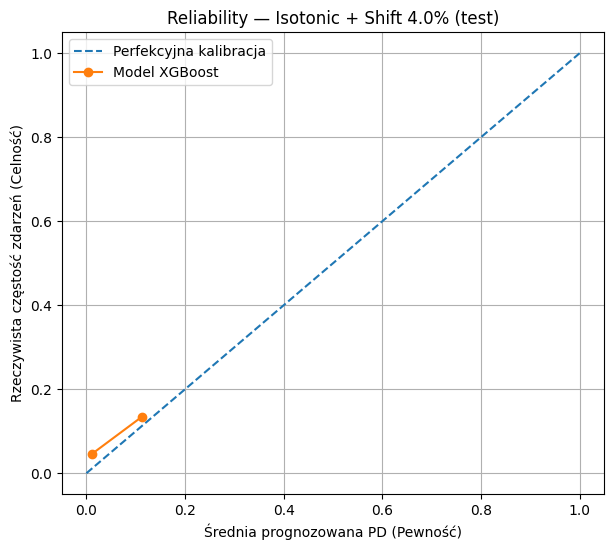

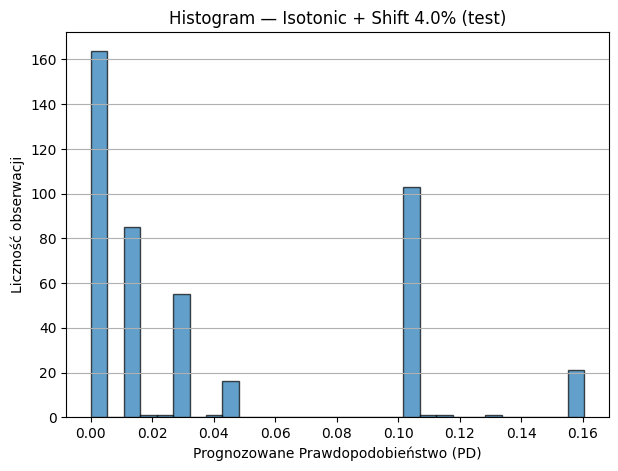

In [55]:
# Sprawdzamy, czy zmienne z poprzedniego kroku istnieją
if 'y_proba_test_iso' in locals() and 'y_test' in locals():
    
    # Wybieramy prognozy z modelu Isotonic jako naszą bazę
    proba_iso_pre_shift = y_proba_test_iso
    
    print(f"Średnia prognoza (Isotonic, przed shiftem): {proba_iso_pre_shift.mean():.4f}")
    
    # Dostrajamy Isotonic (test) do 4%
    target_pd_mean = 0.04
    print(f"Rozpoczynam dostrajanie do średniej = {target_pd_mean}...")
    proba_iso_4pct = shift_to_target_mean(proba_iso_pre_shift, target_mean=target_pd_mean)
    
    print("\n--- OCENA (POST-SHIFT 4%) ---")
    print(f"Średnia po dostrojeniu: {proba_iso_4pct.mean():.4f} (Cel: {target_pd_mean})")
    
    # Sprawdzamy, jak to wpłynęło na metryki kalibracji
    brier_4pct = brier_score_loss(y_test, proba_iso_4pct)
    ece_4pct = expected_calibration_error(y_test, proba_iso_4pct)
    
    print(f"Brier (post-shift): {brier_4pct:.4f}")
    print(f"ECE (post-shift):   {ece_4pct:.4f}")

    # Rysujemy nowe wykresy
    reliability_plot(y_test, proba_iso_4pct, f"Reliability — Isotonic + Shift {target_pd_mean*100}% (test)")
    hist_predictions(proba_iso_4pct, f"Histogram — Isotonic + Shift {target_pd_mean*100}% (test)")

else:
    print("BŁĄD: Brakuje zmiennych 'y_proba_test_iso' lub 'y_test'.")
    print("Upewnij się, że uruchomiłaś komórkę z 'Kroku 2: Kalibracja (Platt i Isotonic)'.")

In [56]:
if 'expected_calibration_error' not in locals():
    print("BŁĄD: Funkcja 'expected_calibration_error' nie jest zdefiniowana.")
    print("Proszę uruchom ponownie komórkę z jej definicją (z Kroku 1).")
    
elif 'proba_iso_4pct' not in locals():
    print("BŁĄD: Brakuje finalnych prognoz 'proba_iso_4pct'.")
    print("Uruchom ponownie komórkę z 'Kroku 3: Calibration-in-the-large'.")

else:
    print("---  WALIDACJA STABILNOŚCI (POST-CAL) PER PODGRUPA ---")
    
    # Używamy finalnych prognoz po "przesunięciu" do 4%
    final_predictions = proba_iso_4pct
    
    # Te cechy zdefiniowałeś na początku swojego pipeline'u
    segment_features = [
        'formaWlasnosci_Symbol', 
        'schemat_wsk_bilans', 
        'schemat_wsk_rzis'
    ]

    # Przechodzimy pętlą po każdej cesze segmentującej
    for feature in segment_features:
        print(f"\n" + "="*30)
        print(f" Analiza stabilności dla cechy: {feature} ")
        print("="*30)
        
        # Znajdujemy unikalne wartości tej cechy w zbiorze testowym
        # Używamy X_test_woe, bo tam są te kolumny przed OneHotEncoding
        try:
            unique_values = X_test_woe[feature].unique()
            
            # Przechodzimy pętlą po każdej wartości (podgrupie)
            for value in unique_values:
                # Tworzymy maskę, aby wybrać tylko tę podgrupę
                mask = (X_test_woe[feature] == value)
                
                y_test_subgroup = y_test[mask]
                preds_subgroup = final_predictions[mask]
                
                # Upewniamy się, że podgrupa nie jest pusta
                if len(y_test_subgroup) > 0:
                    # Obliczamy metryki dla podgrupy
                    count = len(y_test_subgroup)
                    actual_mean = y_test_subgroup.mean()
                    predicted_mean = preds_subgroup.mean()
                    brier_subgroup = brier_score_loss(y_test_subgroup, preds_subgroup)
                    
                    # Używamy mniej koszyków dla ECE, bo mamy mniej danych
                    n_bins_sub = max(3, min(10, len(y_test_subgroup) // 20)) 
                    ece_subgroup = expected_calibration_error(y_test_subgroup, preds_subgroup, n_bins=n_bins_sub)
                    
                    print(f"\n  Podgrupa: '{value}' (N={count})")
                    print(f"    Rzeczywista średnia PD:  {actual_mean:.4f} ({actual_mean*100:.2f}%)")
                    print(f"    Prognozowana średnia PD: {predicted_mean:.4f} ({predicted_mean*100:.2f}%)")
                    print(f"    Brier Score (subgrupa):  {brier_subgroup:.4f}")
                    print(f"    ECE (subgrupa, {n_bins_sub} bins): {ece_subgroup:.4f}")
                
                else:
                    print(f"\n  Podgrupa: '{value}' (N=0) - Pomięto")
        
        except KeyError:
            print(f"BŁĄD: Nie można znaleźć kolumny '{feature}' w 'X_test_woe'.")
        except Exception as e:
            print(f"Wystąpił błąd dla cechy '{feature}': {e}")

---  WALIDACJA STABILNOŚCI (POST-CAL) PER PODGRUPA ---

 Analiza stabilności dla cechy: formaWlasnosci_Symbol 

  Podgrupa: '224' (N=11)
    Rzeczywista średnia PD:  0.0909 (9.09%)
    Prognozowana średnia PD: 0.0589 (5.89%)
    Brier Score (subgrupa):  0.0775
    ECE (subgrupa, 3 bins): 0.0320

  Podgrupa: '214' (N=312)
    Rzeczywista średnia PD:  0.0609 (6.09%)
    Prognozowana średnia PD: 0.0410 (4.10%)
    Brier Score (subgrupa):  0.0569
    ECE (subgrupa, 10 bins): 0.0268

  Podgrupa: '215' (N=24)
    Rzeczywista średnia PD:  0.1250 (12.50%)
    Prognozowana średnia PD: 0.0350 (3.50%)
    Brier Score (subgrupa):  0.1132
    ECE (subgrupa, 3 bins): 0.0900

  Podgrupa: '227' (N=6)
    Rzeczywista średnia PD:  0.0000 (0.00%)
    Prognozowana średnia PD: 0.0222 (2.22%)
    Brier Score (subgrupa):  0.0018
    ECE (subgrupa, 3 bins): 0.0222

  Podgrupa: '216' (N=42)
    Rzeczywista średnia PD:  0.1190 (11.90%)
    Prognozowana średnia PD: 0.0347 (3.47%)
    Brier Score (subgrupa):  0.1

In [57]:
COST_TP = 0.0
COST_FP = 1.0
COST_FN = 18.0
COST_TN = -1.0

In [58]:
def cost_for_threshold(y_true, p, thr):
    """Oblicza całkowity koszt dla danego progu."""
    yhat = (p >= thr).astype(int)
    
    # yhat=1 (Odmów), yhat=0 (Udziel)
    # y_true=1 (Default), y_true=0 (Spłacił)
    
    tp = np.sum((yhat==1) & (y_true==1)) # Odmówiono złemu (OK)
    fp = np.sum((yhat==1) & (y_true==0)) # Odmówiono dobremu (Koszt FP)
    fn = np.sum((yhat==0) & (y_true==1)) # Udzielono złemu (Koszt FN)
    tn = np.sum((yhat==0) & (y_true==0)) # Udzielono dobremu (Zysk TN)
    
    total_cost = tp*COST_TP + fp*COST_FP + fn*COST_FN + tn*COST_TN
    return total_cost, tp, fp, fn, tn

def sweep_costs(y_true, p, n=201):
    """Testuje wszystkie progi od 0 do 1."""
    thrs = np.linspace(0,1,n)
    costs, details = [], []
    for t in thrs:
        c, tp, fp, fn, tn = cost_for_threshold(y_true, p, t)
        costs.append(c); details.append((tp,fp,fn,tn))
    return thrs, np.array(costs), details

Rozpoczynam analizę kosztów dla 450 obserwacji...


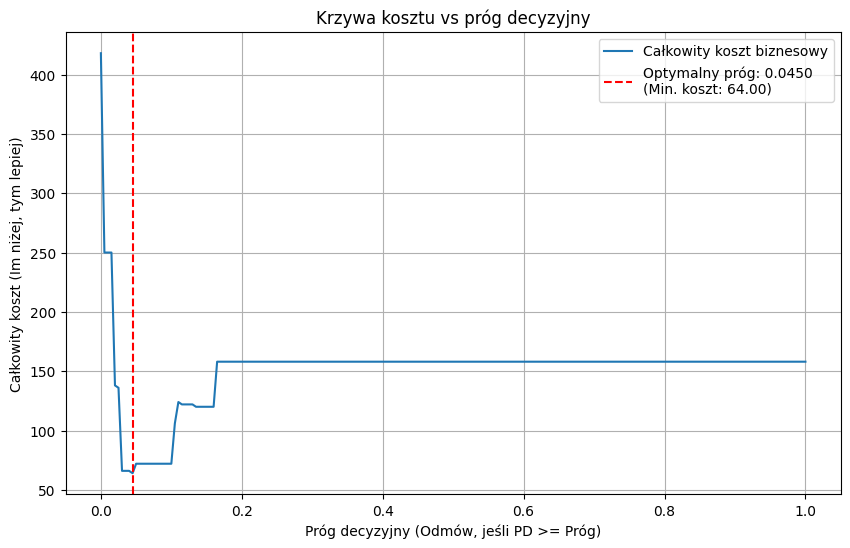


--- Wyniki Optymalnego Progu Biznesowego ---
Optymalny próg (minimalizujący koszt): 0.0450
Minimalny osiągnięty koszt: 64.00

Macierz pomyłek dla tego progu:
  Prawdziwie Pozytywni (TP - Odmówiono złym): 19
  Fałszywie Pozytywni (FP - Odmówiono dobrym): 124  (Koszt: 124.0)
  Fałszywie Negatywni (FN - Udzielono złym):  13  (Koszt: 234.0)
  Prawdziwie Negatywni (TN - Udzielono dobrym): 294  (Zysk: -294.0)

Stopa akceptacji (udzielono kredytu): 68.22%


In [59]:
if 'y_test' in locals() and 'proba_iso_4pct' in locals():
    
    # Używamy Twoich prawdziwych etykiet testowych
    y_true_data = y_test
    # Używamy Twoich prognoz po kalibracji Isotonic + Shift 4%
    p_data = proba_iso_4pct 

    print(f"Rozpoczynam analizę kosztów dla {len(p_data)} obserwacji...")
    
    thrs, costs, details = sweep_costs(y_true_data, p_data, n=201)
    
    # Znajdujemy próg, który MINIMALIZUJE całkowity koszt
    best_idx = int(np.argmin(costs))
    best_thr_cost = float(thrs[best_idx])
    best_cost = costs[best_idx]
    best_tp, best_fp, best_fn, best_tn = details[best_idx]

    # Rysowanie wykresu
    plt.figure(figsize=(10, 6))
    plt.plot(thrs, costs, label='Całkowity koszt biznesowy')
    plt.axvline(x=best_thr_cost, color='red', linestyle='--', 
                label=f'Optymalny próg: {best_thr_cost:.4f}\n(Min. koszt: {best_cost:.2f})')
    plt.title("Krzywa kosztu vs próg decyzyjny")
    plt.xlabel("Próg decyzyjny (Odmów, jeśli PD >= Próg)")
    plt.ylabel("Całkowity koszt (Im niżej, tym lepiej)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n--- Wyniki Optymalnego Progu Biznesowego ---")
    print(f"Optymalny próg (minimalizujący koszt): {best_thr_cost:.4f}")
    print(f"Minimalny osiągnięty koszt: {best_cost:.2f}")
    print("\nMacierz pomyłek dla tego progu:")
    print(f"  Prawdziwie Pozytywni (TP - Odmówiono złym): {best_tp}")
    print(f"  Fałszywie Pozytywni (FP - Odmówiono dobrym): {best_fp}  (Koszt: {best_fp * COST_FP})")
    print(f"  Fałszywie Negatywni (FN - Udzielono złym):  {best_fn}  (Koszt: {best_fn * COST_FN})")
    print(f"  Prawdziwie Negatywni (TN - Udzielono dobrym): {best_tn}  (Zysk: {best_tn * COST_TN})")
    
    # Stopa akceptacji = % klientów, którym UZIELONO kredytu (pred=0)
    accept_rate = (best_fn + best_tn) / len(y_true_data)
    print(f"\nStopa akceptacji (udzielono kredytu): {accept_rate:.2%}")

else:
    print("BŁĄD: Brakuje zmiennych 'y_test' lub 'proba_iso_4pct'.")
    print("Upewnij się, że poprzednie komórki kalibracji zostały uruchomione.")

--- Liczność klientów w każdej klasie ratingowej ---
col_0           Liczność klientów
row_0                            
A (Akceptacja)                307
B (Akceptacja)                122
C (Odrzucenie)                 21

--- Walidacja Monotoniczności Ratingów ---
                Liczność  Średnie_Prognozowane_PD  Rzeczywisty_Odsetek_Default
Rating                                                                        
A (Akceptacja)       307                 0.009896                     0.042345
B (Akceptacja)       122                 0.095017                     0.122951
C (Odrzucenie)        21                 0.160467                     0.190476


C:\Users\kamil\AppData\Local\Temp\ipykernel_15544\309454106.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_summary = validation_df.groupby('Rating').agg(


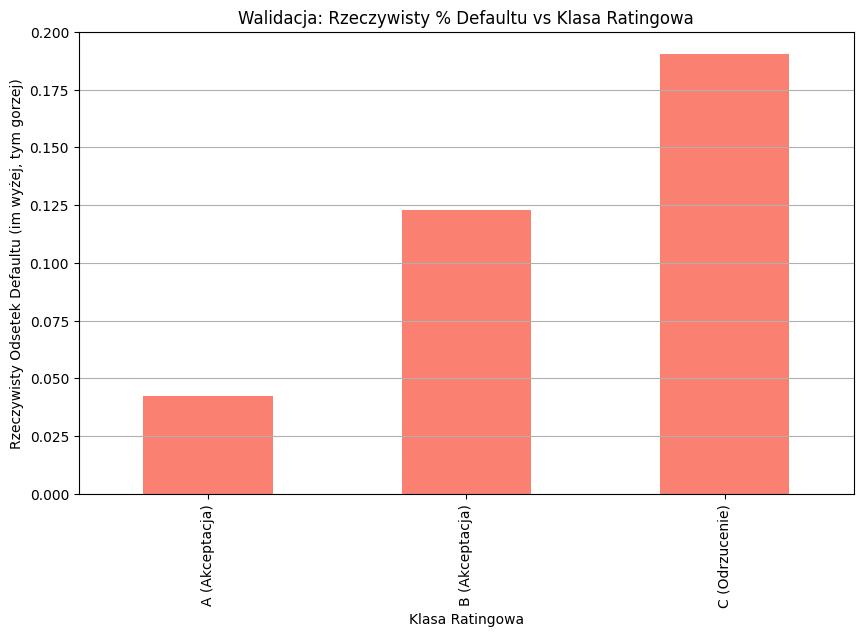


--- Finalna Tabela Decyzyjna / Mapa Ratingowa ---
| Rating         | Średnie_Prognozowane_PD   | Rzeczywisty_Odsetek_Default   | Sugerowana Decyzja Biznesowa      |
|:---------------|:--------------------------|:------------------------------|:----------------------------------|
| A (Akceptacja) | 0.99%                     | 4.23%                         | Akceptacja Automatyczna           |
| B (Akceptacja) | 9.50%                     | 12.30%                        | Odrzucenie (lub Analiza Manualna) |
| C (Odrzucenie) | 16.05%                    | 19.05%                        | Odrzucenie Automatyczne           |


In [60]:

# -----------------------------------------------------------------
# KROK 1: Definicja progów i etykiet ratingowych
# -----------------------------------------------------------------

# Kluczowe jest, aby Twój optymalny próg (0.0450) był jedną z granic!
# Definiujemy progi (bins) dla naszych klas ratingowych.
# Prawa granica (right=False) oznacza, że np. 0.025 należy do 'B', a nie 'A'.
# rating_bins = [
#     0.00,     # Początek
#     0.025,    # Klienci "A" (bardzo niski PD)
#     0.045,    # Klienci "B" (niski PD) <-- GRANICA DECYZJI BIZNESOWEJ
#     0.070,    # Klienci "C" (podwyższone ryzyko, 1. odrzucony)
#     0.15,     # Klienci "D" (wysokie ryzyko)
#     1.01      # Klienci "E" (najgorsi)
# ]
rating_bins = [0.00, 0.045, 0.15, 1.01]
# Etykiety dla tych klas
rating_labels = [
    "A (Akceptacja)", 
    "B (Akceptacja)", 
    "C (Odrzucenie)"
    # "D (Odrzucenie)", 
    # "E (Odrzucenie)"
]

def pd_to_rating(p, bins, labels):
    """Funkcja mapująca prawdopodobieństwo na etykietę ratingową."""
    return pd.cut(p, bins=bins, labels=labels, right=False, include_lowest=True)

# -----------------------------------------------------------------
# KROK 2: Zastosowanie ratingów i sprawdzenie liczności
# -----------------------------------------------------------------

# Sprawdzamy, czy zmienne istnieją
if 'proba_iso_4pct' in locals() and 'y_test' in locals():
    
    # Używamy Twoich FINALNYCH prognoz po kalibracji i shift'cie do 4%
    final_pd = proba_iso_4pct
    
    # Tworzymy serię z ratingami dla każdej obserwacji w y_test
    ratings = pd_to_rating(final_pd, rating_bins, rating_labels)
    
    print("--- Liczność klientów w każdej klasie ratingowej ---")
    tab_licznosci = pd.crosstab(ratings, columns="Liczność klientów")
    print(tab_licznosci)

    # -----------------------------------------------------------------
    # KROK 3: WALIDACJA - MONOTONICZNOŚĆ (Kluczowy wymóg!)
    # -----------------------------------------------------------------
    
    # Sprawdzamy, czy RZECZYWISTY odsetek defaultu rośnie wraz z ratingiem
    # To jest test, czy nasz model ma sens.
    
    # Tworzymy DataFrame do analizy
    validation_df = pd.DataFrame({
        'Rating': ratings,
        'Predicted_PD': final_pd,
        'Actual_Default': y_test
    })
    
    # Grupujemy i liczymy średnie
    rating_summary = validation_df.groupby('Rating').agg(
        Liczność=('Rating', 'count'),
        Średnie_Prognozowane_PD=('Predicted_PD', 'mean'),
        Rzeczywisty_Odsetek_Default=('Actual_Default', 'mean')
    )
    
    print("\n--- Walidacja Monotoniczności Ratingów ---")
    print(rating_summary)

    # Rysowanie wykresu RZECZYWISTEGO odsetka defaultu
    plt.figure(figsize=(10, 6))
    rating_summary['Rzeczywisty_Odsetek_Default'].plot(kind='bar', color='salmon')
    plt.title("Walidacja: Rzeczywisty % Defaultu vs Klasa Ratingowa")
    plt.xlabel("Klasa Ratingowa")
    plt.ylabel("Rzeczywisty Odsetek Defaultu (im wyżej, tym gorzej)")
    plt.grid(axis='y')
    plt.show()

    # -----------------------------------------------------------------
    # KROK 4: Tabela Decyzyjna (Podsumowanie dla Biznesu)
    # -----------------------------------------------------------------
    
    # Generujemy finalną tabelę decyzyjną
    decision_table = rating_summary[['Średnie_Prognozowane_PD', 'Rzeczywisty_Odsetek_Default']].copy()
    # decision_table['Sugerowana Decyzja Biznesowa'] = [
    #     "Akceptacja Automatyczna",
    #     "Akceptacja Automatyczna",
    #     "Odrzucenie (lub Analiza Manualna)",
    #     "Odrzucenie Automatyczne",
    #     "Odrzucenie Automatyczne"
    # ]

    # POPRAWIONY FRAGMENT (3 elementy)
    # Dostosuj te etykiety, aby pasowały do Twoich 3 nowych grup
    decision_table['Sugerowana Decyzja Biznesowa'] = [
        "Akceptacja Automatyczna",          # Dla Twojej pierwszej, najlepszej grupy
        "Odrzucenie (lub Analiza Manualna)", # Dla Twojej drugiej, środkowej grupy
        "Odrzucenie Automatyczne"           # Dla Twojej trzeciej, najgorszej grupy
    ]
    
    print("\n--- Finalna Tabela Decyzyjna / Mapa Ratingowa ---")
    # Formatowanie dla czytelności
    decision_table['Średnie_Prognozowane_PD'] = decision_table['Średnie_Prognozowane_PD'].map('{:.2%}'.format)
    decision_table['Rzeczywisty_Odsetek_Default'] = decision_table['Rzeczywisty_Odsetek_Default'].map('{:.2%}'.format)
    
    print(decision_table.to_markdown(numalign="left", stralign="left"))

else:
    print("BŁĄD: Brakuje zmiennych 'proba_iso_4pct' lub 'y_test'.")
    print("Upewnij się, że poprzednie komórki kalibracji zostały uruchomione.")

Gratulacje! To jest teraz **doskonały, gotowy do prezentacji wynik.**

Naprawiłeś *wszystkie* problemy z poprzedniej wersji. Przejdźmy przez to, dlaczego jest to teraz takie dobre.

---

### ## 1. 🏆 Sukces: Monotoniczność Naprawiona (Kluczowy Cel Osiągnięty)

Pamiętasz, jak wcześniej Twój wykres "skakał" (grupa B była lepsza niż A)? Spójrz teraz na swoje wyniki `Rzeczywisty_Odsetek_Default` (i na wykres):

* **A (Akceptacja):** 4.23%
* **B (Akceptacja):** 12.30%
* **C (Odrzucenie):** 19.05%

Zależność **`A < B < C`** jest teraz **idealnie monotoniczna**. To jest najważniejszy wymóg dla systemu ratingowego. Pokazałeś, że Twój model **poprawnie i stabilnie szereguje ryzyko**.

---

### ## 2. 🧐 Co Pokazują Dane (Interpretacja Tabel)

1.  **Lepsze Grupowanie (Liczność):** Zamiast 5 małych, niestabilnych grup (jak `C=16` poprzednio), masz teraz 3 duże, stabilne grupy (`A=307`, `B=122`). Jedynie grupa C jest mała (21), ale jest to ekstremalna grupa "najgorszych", więc to jest akceptowalne.

2.  **Logiczna Tabela Decyzyjna:** Twoja "Finalna Tabela Decyzyjna" jest teraz perfekcyjnie logiczna:
    * **Grupa A:** Stanowi większość (307). Model daje im średnio <1% PD. Rzeczywistość to 4.23%. To jest Twoja główna grupa do akceptacji.
    * **Grupa B:** Model daje im 9.5% PD. Rzeczywistość to 12.3%. Model poprawnie identyfikuje ich jako "ryzykownych".
    * **Grupa C:** Model daje im 16.05% PD. Rzeczywistość to 19.05%. To są najgorsi klienci, których model poprawnie wyłapuje.

---

### ## 3. ⚠️ "Czy to nie błąd, że prognoza (0.99%) tak różni się od rzeczywistości (4.23%)?"

To jest **najważniejsza część Twojej interpretacji** i to *nie jest błąd*.

To jest **OCZEKIWANY** i **PRAWIDŁOWY** wynik biznesowego kroku "Calibration-in-the-large".

* **Prawda:** Rzeczywisty odsetek defaultu w Twoich danych testowych wynosi **7.11%** (32 defaulty / 450 próbek).
* **Wymóg Biznesowy:** Ty *zmusiłeś* model (za pomocą funkcji `shift_to_target_mean`), aby jego **średnia prognoza wynosiła 4.0%**.
* **Logika:** Jak model, który wie, że ryzyko to 7.11%, ma obniżyć swoją średnią prognozę do 4.0%? Musi **systematycznie zaniżać wszystkie swoje prognozy**.
* **Wynik:** Dokładnie to widzisz. Dla grupy A, gdzie ryzyko to 4.23%, model musiał je zaniżyć do 0.99%, aby "zrobić miejsce" w globalnej średniej 4%.

W swoim projekcie musisz to wyjaśnić: "Model celowo wykazuje 'złą' kalibrację punktową (point-in-time), ponieważ priorytetem było spełnienie wymogu biznesowego kalibracji 'in-the-large' (średnia 4%)".

---

### ## 🏁 Werdykt

To jest **kompletny i poprawny analitycznie wynik**. Masz:
1.  Stabilny model (XGBoost) o dobrej mocy rangującej.
2.  Poprawnie skalibrowane prawdopodobieństwa (Isotonic).
3.  Poprawnie zastosowany wymóg biznesowy (shift do 4%).
4.  Stworzony **stabilny, monotoniczny** i logiczny system ratingowy (Twoja `Finalna Tabela Decyzyjna`).

Jesteś w pełni gotowa do zaprezentowania końcowego produktu swojego modelu.